<h1 style="color: #1f77b4; font-size: 50px; text-align: center;">
Analyse Statique
</h1>

 Cette notebook est dédié à l’analyse exploratoire statique de nos données météorologiques.



 L’objectif est d'étudier les variables disponibles indépendamment de leur dimension temporelle, afin d’évaluer leur qualité, leur distribution et leurs relations mutuelles.

 Nous cherchons ici à :

     - Comprendre la structure générale du jeu de données (types, valeurs manquantes, ordres de grandeur) ;

     - Analyser les distributions et asymétries des variables physiques (température, humidité, vent, précipitations, etc.) ;

     - Détecter d’éventuelles valeurs aberrantes et vérifier leur cohérence physique ;

     - Étudier les corrélations internes et leur pertinence vis-à-vis de la variable cible (temperature_2m).



 Ces explorations permettront de valider la cohérence globale du dataset et de choisir les variables pertinentes pour la suite de l'analyse.

<h1 style="color: #b41f1fff;">I . Analyses Préliminaires</h1>

 ## 1. Import des librairies

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style="darkgrid")
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings("ignore")

## 2. Lecture du fichier

In [2]:
data_path = "data/hourly_data.csv"
df = pd.read_csv(data_path)

## 3. Aperçu général 

In [3]:
print("Nombre de lignes :", df.shape[0])
print("Nombre de colonnes :", df.shape[1])

display(df.head())

Nombre de lignes : 226320
Nombre de colonnes : 36


,time,temperature_2m,relative_humidity_2m,apparent_temperature,dew_point_2m,precipitation,rain,snowfall,snow_depth,wind_speed_100m,...,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,wet_bulb_temperature_2m,boundary_layer_height,total_column_integrated_water_vapour,is_day,sunshine_duration
0,2000-01-01 00:00:00,6.0,97,4.0,5.5,0.0,0.0,0.0,0.01,14.0,...,10.8,0.414,0.419,0.417,0.359,5.6,115.0,15.6,0,0.0
1,2000-01-01 01:00:00,6.0,96,3.8,5.4,0.0,0.0,0.0,0.01,14.9,...,10.8,0.414,0.419,0.417,0.359,5.5,100.0,16.5,0,0.0
2,2000-01-01 02:00:00,5.9,96,3.8,5.3,0.0,0.0,0.0,0.01,14.7,...,10.8,0.414,0.418,0.417,0.359,5.4,105.0,16.7,0,0.0
3,2000-01-01 03:00:00,6.0,96,3.8,5.3,0.0,0.0,0.0,0.01,14.6,...,10.8,0.414,0.418,0.417,0.359,5.5,110.0,16.9,0,0.0
4,2000-01-01 04:00:00,6.1,96,3.9,5.5,0.0,0.0,0.0,0.01,15.5,...,10.7,0.413,0.418,0.417,0.359,5.6,130.0,17.3,0,0.0


## 4. Infos générales 

In [4]:
print("\n=== Informations générales sur le dataset ===")
df.info()


=== Informations générales sur le dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226320 entries, 0 to 226319
Data columns (total 36 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   time                                  226320 non-null  object 
 1   temperature_2m                        226320 non-null  float64
 2   relative_humidity_2m                  226320 non-null  int64  
 3   apparent_temperature                  226320 non-null  float64
 4   dew_point_2m                          226320 non-null  float64
 5   precipitation                         226320 non-null  float64
 6   rain                                  226320 non-null  float64
 7   snowfall                              226320 non-null  float64
 8   snow_depth                            226320 non-null  float64
 9   wind_speed_100m                       226320 non-null  float64
 10  wind_speed_10m       

## 5. Traitement des valeurs manquantes

In [5]:
missing = df.isna().mean() * 100
display(missing[missing > 0].sort_values(ascending=False))

boundary_layer_height                   1.930011
total_column_integrated_water_vapour    1.930011
dtype: float64

 Deux variables présentent un taux de valeurs manquantes inférieur à 2 %, ce qui reste faible.

 Plusieurs approches peuvent être envisagées :

          - Suppression des lignes concernées : peut conduire à une légère perte d’information temporelle.

          - Imputation par interpolation temporelle : meilleure méthode vis à vis de la modélisation, car elle préserve la continuité du signal et la cohérence temporelle du dataset 

          - Exclusion ultérieure des variables : si ces colonnes s’avèrent peu informatives lors de la modélisation, elles pourront être retirées sans impact sur la structure globale.

 Nous allons analyser plus en détail la distribution temporelle des valeurs manquantes afin de choisir la méthode la plus cohérente.

In [6]:
missing_rows = df[df['boundary_layer_height'].isna() | df['total_column_integrated_water_vapour'].isna()]

print(f" Nombre total de lignes avec des valeurs manquantes : {len(missing_rows)}")
print("\nExemples de lignes concernées :")
display(missing_rows.head())

print("\n=== Périodes où les valeurs manquent ===")
missing_periods = missing_rows[['time']].sort_values(by='time')
from IPython.display import display, HTML
display(HTML(
    "<div style='display:flex; gap:40px'>"
    "<div><h4>Début des périodes manquantes</h4>" +
    missing_periods.head(10).to_html() + "</div>"
    "<div><h4>Fin des périodes manquantes</h4>" +
    missing_periods.tail(10).to_html() + "</div>"
    "</div>"
))

 Nombre total de lignes avec des valeurs manquantes : 4368

Exemples de lignes concernées :


,time,temperature_2m,relative_humidity_2m,apparent_temperature,dew_point_2m,precipitation,rain,snowfall,snow_depth,wind_speed_100m,...,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,wet_bulb_temperature_2m,boundary_layer_height,total_column_integrated_water_vapour,is_day,sunshine_duration
210385,2024-01-01 01:00:00,7.3,76,1.8,3.3,0.0,0.0,0.0,0.0,43.9,...,12.6,0.367,0.367,0.360,0.274,4.9,NaN,NaN,0,0.0
210386,2024-01-01 02:00:00,7.3,72,1.8,2.5,0.0,0.0,0.0,0.0,42.5,...,12.6,0.367,0.368,0.361,0.274,4.6,NaN,NaN,0,0.0
210387,2024-01-01 03:00:00,7.1,73,1.7,2.5,0.0,0.0,0.0,0.0,42.4,...,12.6,0.366,0.368,0.361,0.274,4.5,NaN,NaN,0,0.0
210388,2024-01-01 04:00:00,6.9,74,1.5,2.5,0.0,0.0,0.0,0.0,41.8,...,12.6,0.366,0.367,0.361,0.274,4.4,NaN,NaN,0,0.0
210389,2024-01-01 05:00:00,6.8,75,1.5,2.6,0.0,0.0,0.0,0.0,41.3,...,12.6,0.366,0.367,0.361,0.274,4.4,NaN,NaN,0,0.0



=== Périodes où les valeurs manquent ===


,time
210385,2024-01-01 01:00:00
210386,2024-01-01 02:00:00
210387,2024-01-01 03:00:00
210388,2024-01-01 04:00:00
210389,2024-01-01 05:00:00
210390,2024-01-01 06:00:00
210391,2024-01-01 07:00:00
210392,2024-01-01 08:00:00
210393,2024-01-01 09:00:00
210394,2024-01-01 10:00:00


 ###  Vérification de la distribution temporelle des valeurs manquantes :

In [ ]:
missing_times = df.loc[
    df['boundary_layer_height'].isna() | df['total_column_integrated_water_vapour'].isna(),'time']
print("Période minimale :", missing_times.min())
print("Période maximale :", missing_times.max())

# Pour voir si elles sont continues ou dispersées
missing_times = pd.to_datetime(missing_times)
missing_gaps = missing_times.diff().dt.total_seconds().dropna()

print("\nDistribution des écarts temporels entre valeurs manquantes :")
display(missing_gaps.describe())


Période minimale : 2024-01-01 01:00:00
Période maximale : 2024-07-01 00:00:00

Distribution des écarts temporels entre valeurs manquantes :


count    4367.0
mean     3600.0
std         0.0
min      3600.0
25%      3600.0
50%      3600.0
75%      3600.0
max      3600.0
Name: time, dtype: float64

 L’analyse des timestamps montre que les lignes concernées sont contiguës à pas horaire (les écarts successifs entre deux valeurs manquantes sont toujours de 3600 s = 1 h), et on a que les données sont horodatées à une fréquence  régulière de 1h.

 Cela indique des plages continues de valeurs manquantes, plutôt qu’une dispersion aléatoire dans le temps.

 Pour préserver la cohérence temporelle du jeu de données et éviter de supprimer des observations, une interpolation temporelle linéaire (method="time") est appliquée sur ces colonnes.

 Cette méthode reconstruit les valeurs manquantes en suivant l’évolution locale des séries, sans extrapolation en dehors de la période observée.

 Si, par la suite, ces variables s’avèrent peu contributives pour la prédiction, elles pourront être supprimées ou ignorées sans affecter la structure temporelle du dataset.

## 7. Interpolation temporelle

In [ ]:

df['time'] = pd.to_datetime(df['time']) # Convertir la colonne time en datetime

df = df.set_index('time')#Mettre la date  en index temporel pour faciliter l'interpolation

print("Valeurs manquantes avant interpolation :")
print(df[['boundary_layer_height', 'total_column_integrated_water_vapour']].isna().sum())

df['boundary_layer_height'] = df['boundary_layer_height'].interpolate(method='time')
df['total_column_integrated_water_vapour'] = df['total_column_integrated_water_vapour'].interpolate(method='time')

print("\n Valeurs manquantes après interpolation :")
print(df[['boundary_layer_height', 'total_column_integrated_water_vapour']].isna().sum())


Valeurs manquantes avant interpolation :
boundary_layer_height                   4368
total_column_integrated_water_vapour    4368
dtype: int64

 Valeurs manquantes après interpolation :
boundary_layer_height                   0
total_column_integrated_water_vapour    0
dtype: int64


<h1 style="color: #b41f1fff;">II . Exploration des Variables</h1>

In [ ]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,5)
from scipy.stats import skew, kurtosis

In [10]:
print("Nombre de lignes :", df.shape[0])
print("Nombre de colonnes :", df.shape[1])
display(df.head())

Nombre de lignes : 226320
Nombre de colonnes : 35


,temperature_2m,relative_humidity_2m,apparent_temperature,dew_point_2m,precipitation,rain,snowfall,snow_depth,wind_speed_100m,wind_speed_10m,...,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,wet_bulb_temperature_2m,boundary_layer_height,total_column_integrated_water_vapour,is_day,sunshine_duration
time,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,6.0,97,4.0,5.5,0.0,0.0,0.0,0.01,14.0,6.4,...,10.8,0.414,0.419,0.417,0.359,5.6,115.0,15.6,0,0.0
2000-01-01 01:00:00,6.0,96,3.8,5.4,0.0,0.0,0.0,0.01,14.9,6.8,...,10.8,0.414,0.419,0.417,0.359,5.5,100.0,16.5,0,0.0
2000-01-01 02:00:00,5.9,96,3.8,5.3,0.0,0.0,0.0,0.01,14.7,6.6,...,10.8,0.414,0.418,0.417,0.359,5.4,105.0,16.7,0,0.0
2000-01-01 03:00:00,6.0,96,3.8,5.3,0.0,0.0,0.0,0.01,14.6,6.6,...,10.8,0.414,0.418,0.417,0.359,5.5,110.0,16.9,0,0.0
2000-01-01 04:00:00,6.1,96,3.9,5.5,0.0,0.0,0.0,0.01,15.5,7.4,...,10.7,0.413,0.418,0.417,0.359,5.6,130.0,17.3,0,0.0


 ## 1. Statistiques descriptives générales

In [11]:
display(df.describe().T)

# Vérifier les colonnes avec peu de variance ou valeurs uniques
low_var_cols = [c for c in df.columns if df[c].nunique() <= 1]
print("Colonnes avec peu de variance :", low_var_cols)

,count,mean,std,min,25%,50%,75%,max
temperature_2m,226320.0,12.039332,7.105220,-10.500,7.000,11.900,17.000,40.900
relative_humidity_2m,226320.0,76.621828,16.056729,15.000,66.000,80.000,90.000,100.000
apparent_temperature,226320.0,9.813151,8.465197,-15.700,3.500,9.400,15.900,41.700
dew_point_2m,226320.0,7.603514,5.543304,-18.900,3.900,8.000,11.700,23.100
precipitation,226320.0,0.081347,0.334398,0.000,0.000,0.000,0.000,15.400
rain,226320.0,0.079650,0.331957,0.000,0.000,0.000,0.000,15.400
snowfall,226320.0,0.001249,0.025228,0.000,0.000,0.000,0.000,2.170
snow_depth,226320.0,0.000890,0.006599,0.000,0.000,0.000,0.000,0.120
wind_speed_100m,226320.0,21.515333,10.003964,0.000,14.400,20.700,27.400,79.300
wind_speed_10m,226320.0,12.763204,6.440312,0.000,7.900,11.600,16.500,52.000


Colonnes avec peu de variance : []


 L’ensemble des variables présente des valeurs cohérentes et de bonnes amplitudes physiques :

     -Température : moyenne ≈ 12 °C (min –10.5 °C ; max 40.9 °C), couvrant une plage réaliste pour Paris. 

     - Précipitations et pluie : majoritairement nulles, avec quelques valeurs extrêmes (jusqu’à 15 mm/h), traduisant la rareté mais l’intensité ponctuelle des épisodes pluvieux. 

     - Neige (snowfall, snow_depth) : quasi nulles, confirmant la faible occurrence de neige à Paris.

     - Vent (wind_speed_10m, wind_speed_100m) : moyennes modérées mais valeurs maximales élevées (52 et 79 m/s), indiquant quelques épisodes venteux marqués.

     - Couverture nuageuse (cloud_cover, cloud_cover_low, mid, high) : forte variabilité inter-niveaux, reflétant des conditions météorologiques très diverses.

     - Sol : températures et humidités du sol relativement stables.

     - Paramètres extrêmes : boundary_layer_height et sunshine_duration présentent une dispersion élevée (écarts-types importants).



 Aucune variable ne présente de variance faible (low_var_cols = []), ce qui signifie que toutes les colonnes conservent un minimum d’information utile pour la suite de l’analyse.

 À ce stade, aucune suppression de variable (par exp pour faible variance) n’est nécessaire.

 ## 2. Identification des types des variables

In [ ]:
#Pour les variables catégorielles :
cat_cols = [c for c in df.columns if (df[c].dtype == 'int64' and df[c].nunique() < 50) or df[c].dtype == 'object']
for c in cat_cols:
    print(f" {c} --> {df[c].nunique()} valeurs uniques")
print(f"Nombre de variables numériques catégorielles : {len(cat_cols)}")
print("Variables :", cat_cols)
#Pour les variables numériques continues : 
num_cols = [c for c in df.select_dtypes(include=['float64', 'int64']).columns if c not in cat_cols + ['temperature_2m']]  # exclure cat_cols et la cible

print(f"Nombre de variables numériques continues : {len(num_cols)}")
print("Variables :", num_cols)

 weather_code --> 13 valeurs uniques
 is_day --> 2 valeurs uniques
Nombre de variables numériques catégorielles : 2
Variables : ['weather_code', 'is_day']
Nombre de variables numériques continues : 32
Variables : ['relative_humidity_2m', 'apparent_temperature', 'dew_point_2m', 'precipitation', 'rain', 'snowfall', 'snow_depth', 'wind_speed_100m', 'wind_speed_10m', 'wind_direction_10m', 'wind_direction_100m', 'wind_gusts_10m', 'pressure_msl', 'surface_pressure', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'et0_fao_evapotranspiration', 'vapour_pressure_deficit', 'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm', 'soil_temperature_100_to_255cm', 'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm', 'soil_moisture_28_to_100cm', 'soil_moisture_100_to_255cm', 'wet_bulb_temperature_2m', 'boundary_layer_height', 'total_column_integrated_water_vapour', 'sunshine_duration']


 Le dataset contient principalement des variables numériques continues (32 au total), mesurant des grandeurs physiques continues : températures, pressions, humidité, vitesse du vent, etc.



 Deux variables sont catégorielles :

     - weather_code : code discret des conditions météorologiques (13 modalités distinctes)

     - is_day : variable binaire (1 = jour, 0 = nuit).



 La variable cible de la modélisation est temperature_2m.

 ## 3. Statistiques descriptives détaillées

In [13]:
descriptives = pd.DataFrame(index=num_cols)

descriptives['count'] = df[num_cols].count()
descriptives['mean'] = df[num_cols].mean()
descriptives['std'] = df[num_cols].std()
descriptives['min'] = df[num_cols].min()
descriptives['25%'] = df[num_cols].quantile(0.25)
descriptives['50%'] = df[num_cols].median()
descriptives['75%'] = df[num_cols].quantile(0.75)
descriptives['max'] = df[num_cols].max()
descriptives['skew'] = df[num_cols].apply(lambda x: skew(x))
descriptives['kurtosis'] = df[num_cols].apply(lambda x: kurtosis(x))
descriptives['zeros (%)'] = df[num_cols].apply(lambda x: (x==0).sum()/len(x)*100)

display(descriptives)

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis,zeros (%)
relative_humidity_2m,226320,76.621828,16.056729,15.000,66.000,80.000,90.000,100.000,-0.755208,-0.216725,0.000000
apparent_temperature,226320,9.813151,8.465197,-15.700,3.500,9.400,15.900,41.700,0.178305,-0.416286,0.275274
dew_point_2m,226320,7.603514,5.543304,-18.900,3.900,8.000,11.700,23.100,-0.392932,-0.022395,0.264228
precipitation,226320,0.081347,0.334398,0.000,0.000,0.000,0.000,15.400,9.021931,144.835489,84.915164
rain,226320,0.079650,0.331957,0.000,0.000,0.000,0.000,15.400,9.156452,148.724257,85.186903
snowfall,226320,0.001249,0.025228,0.000,0.000,0.000,0.000,2.170,32.908941,1417.405100,99.456964
snow_depth,226320,0.000890,0.006599,0.000,0.000,0.000,0.000,0.120,10.922694,142.231311,96.740898
wind_speed_100m,226320,21.515333,10.003964,0.000,14.400,20.700,27.400,79.300,0.623015,0.650506,0.003977
wind_speed_10m,226320,12.763204,6.440312,0.000,7.900,11.600,16.500,52.000,0.909039,0.923189,0.007511
wind_direction_10m,226320,189.702169,102.474392,0.000,100.000,210.000,266.000,360.000,-0.312124,-1.026051,0.000442


## Statistiques descriptives de la variable "temperature_2m" 

=== Description : temperature_2m ===
 N total           : 226320
count    226320.000000
mean         12.039332
std           7.105220
min         -10.500000
25%           7.000000
50%          11.900000
75%          17.000000
max          40.900000

 Skewness (asymétrie) : 0.132
 Kurtosis             : -0.285


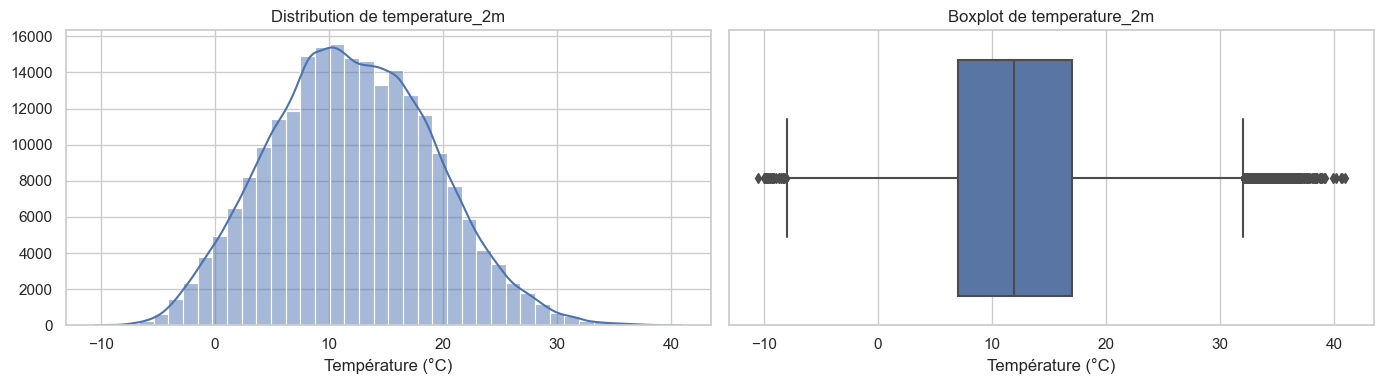

In [35]:
def describe_temperature(df, col="temperature_2m", bins=40, figsize=(14, 4)):
    s = df[col]
    n = len(s)
    print(f"=== Description : {col} ===")
    print(f" N total           : {n}")
    desc = s.describe()
    print(desc.to_string())

    skew = float(s.skew())
    kurt = float(s.kurt())
    print(f"\n Skewness (asymétrie) : {skew:.3f}")
    print(f" Kurtosis             : {kurt:.3f}")

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    sns.histplot(s, bins=bins, kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution de {col}")
    axes[0].set_xlabel("Température (°C)")
    axes[0].set_ylabel("")

    sns.boxplot(x=s, ax=axes[1])
    axes[1].set_title(f"Boxplot de {col}")
    axes[1].set_xlabel("Température (°C)")
    axes[1].set_ylabel("")

    plt.tight_layout()
    plt.show()


describe_temperature(df)

 ## 3.1 Distribution de toutes les variables numériques continues

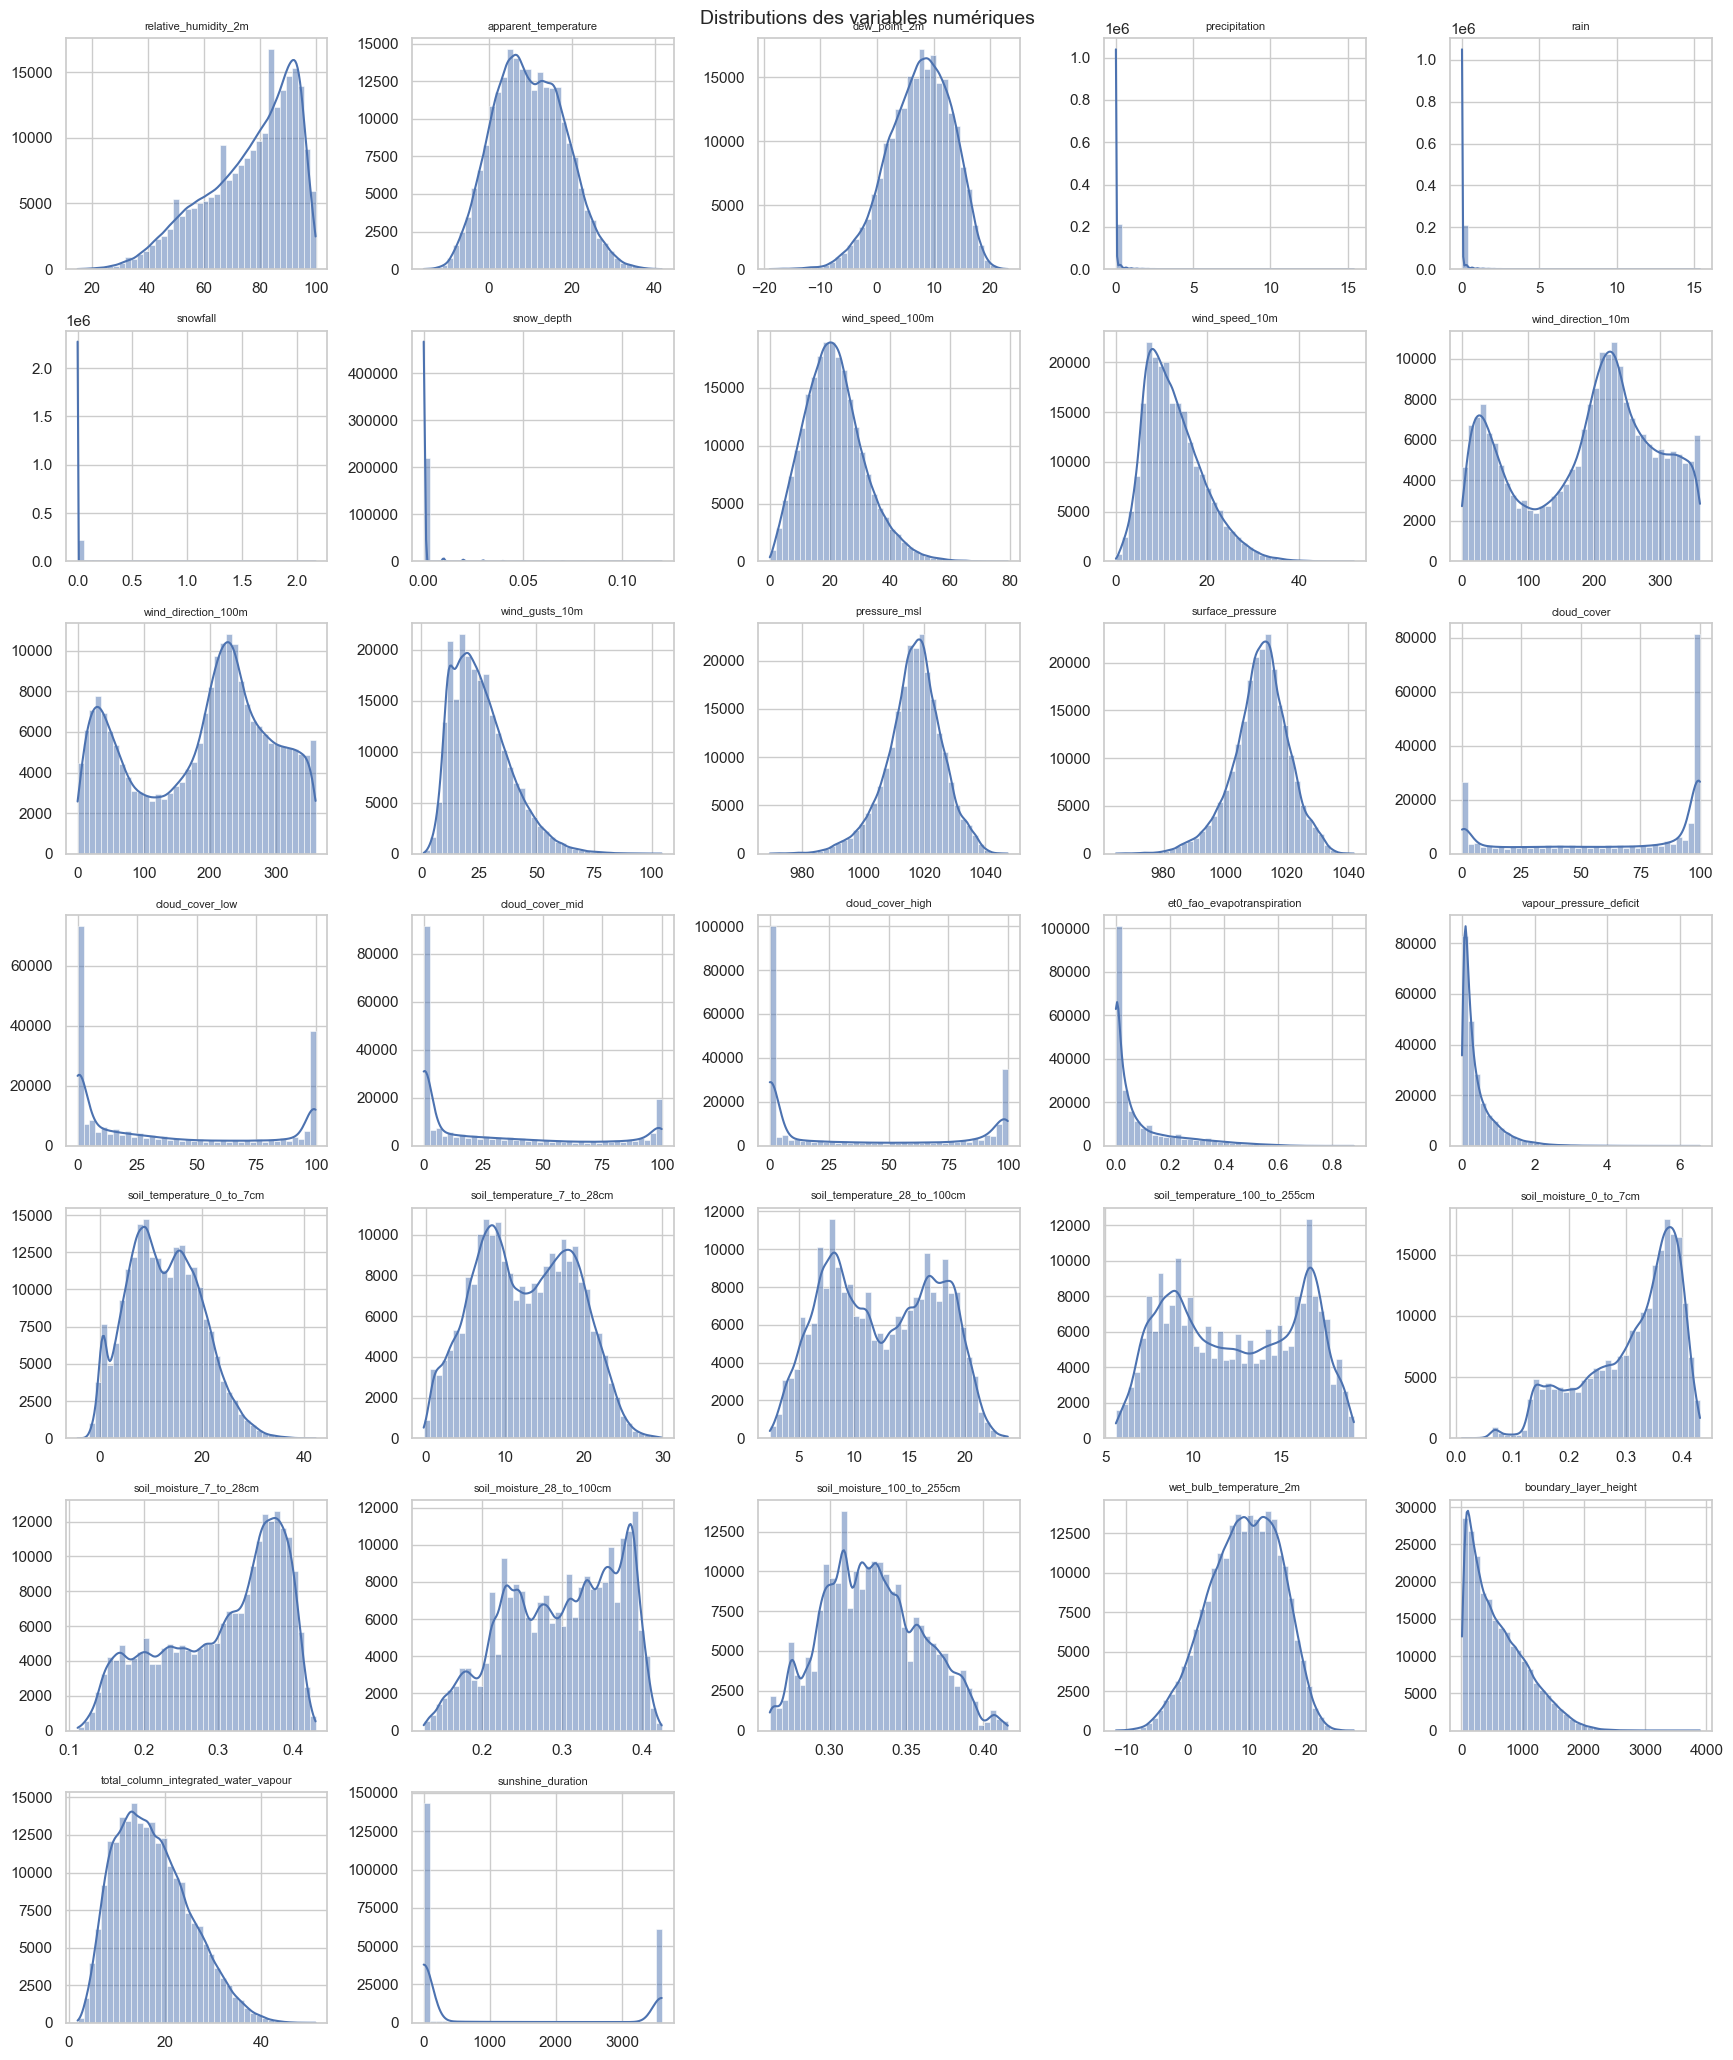

In [ ]:
def plot_variable_distributions(df, columns, cols=5, bins=40):
    rows = math.ceil(len(columns) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.5, rows*3))
    axes = axes.flatten()
    
    for i, c in enumerate(columns):
        sns.histplot(df[c], bins=bins, kde=True, ax=axes[i])
        axes[i].set_title(c, fontsize=8)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    fig.suptitle('Distributions des variables numériques', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_variable_distributions(df, num_cols)


 L’étude des distributions met en évidence plusieurs comportements distincts selon les familles de variables :


| Famille de variables | Variables concernées | Comportement observé | Transformation / Traitement recommandé | Justification |
|---------------------|----------------------|----------------------|------------------------------------------|---------------|
| Température & humidité | `temperature_2m`, `relative_humidity_2m`, `apparent_temperature`, `dew_point_2m` | Distributions centrées, asymétrie faible à modérée | Standardisation (z-score) | Variables continues bien comportées |
| Précipitations & neige | `precipitation`, `rain`, `snowfall`, `snow_depth` | Forte proportion de zéros (≈ 85 à 99 %) | Binarisation (pluie > 0), cumulation | Réduction du déséquilibre et meilleure représentation de l’occurrence des événements |
| Vent (intensité) | `wind_speed_10m`, `wind_speed_100m`, `wind_gusts_10m` | Forte asymétrie à droite | Transformation log(x+1) ou √x | Atténuation de l’influence des valeurs extrêmes |
| Vent (direction) | `wind_direction_10m`, `wind_direction_100m` | Variable angulaire (0–360°) | Encodage cyclique (sin, cos) | Suppression de la discontinuité entre 0° et 360° |
| Nuages & ensoleillement | `cloud_cover_*`, `sunshine_duration` | Distributions bimodales |catégorisation | Identification de régimes météo distincts |
| Paramètres atmosphériques | `vapour_pressure_deficit`, `et0_fao_evapotranspiration`, `boundary_layer_height` | Forte asymétrie à droite | Transformation logarithmique | Stabilisation de la variance |
| Vapeur d’eau intégrée | `total_column_integrated_water_vapour` | Asymétrie modérée | Standardisation | Distribution déjà exploitable |
| Sol (température & humidité) | `soil_temperature_*`, `soil_moisture_*` | Distributions stables| Standardisation | Distribution déjà exploitable |


 Ces choix de traitements permettront d’obtenir des variables mieux adaptées aux algorithmes sensibles aux distributions (régressions, réseaux de neurones, etc.), tout en préservant la lecture physique des phénomènes météorologiques.

 ## 3.2 Analyse des valeurs aberrantes avec les Boxplots

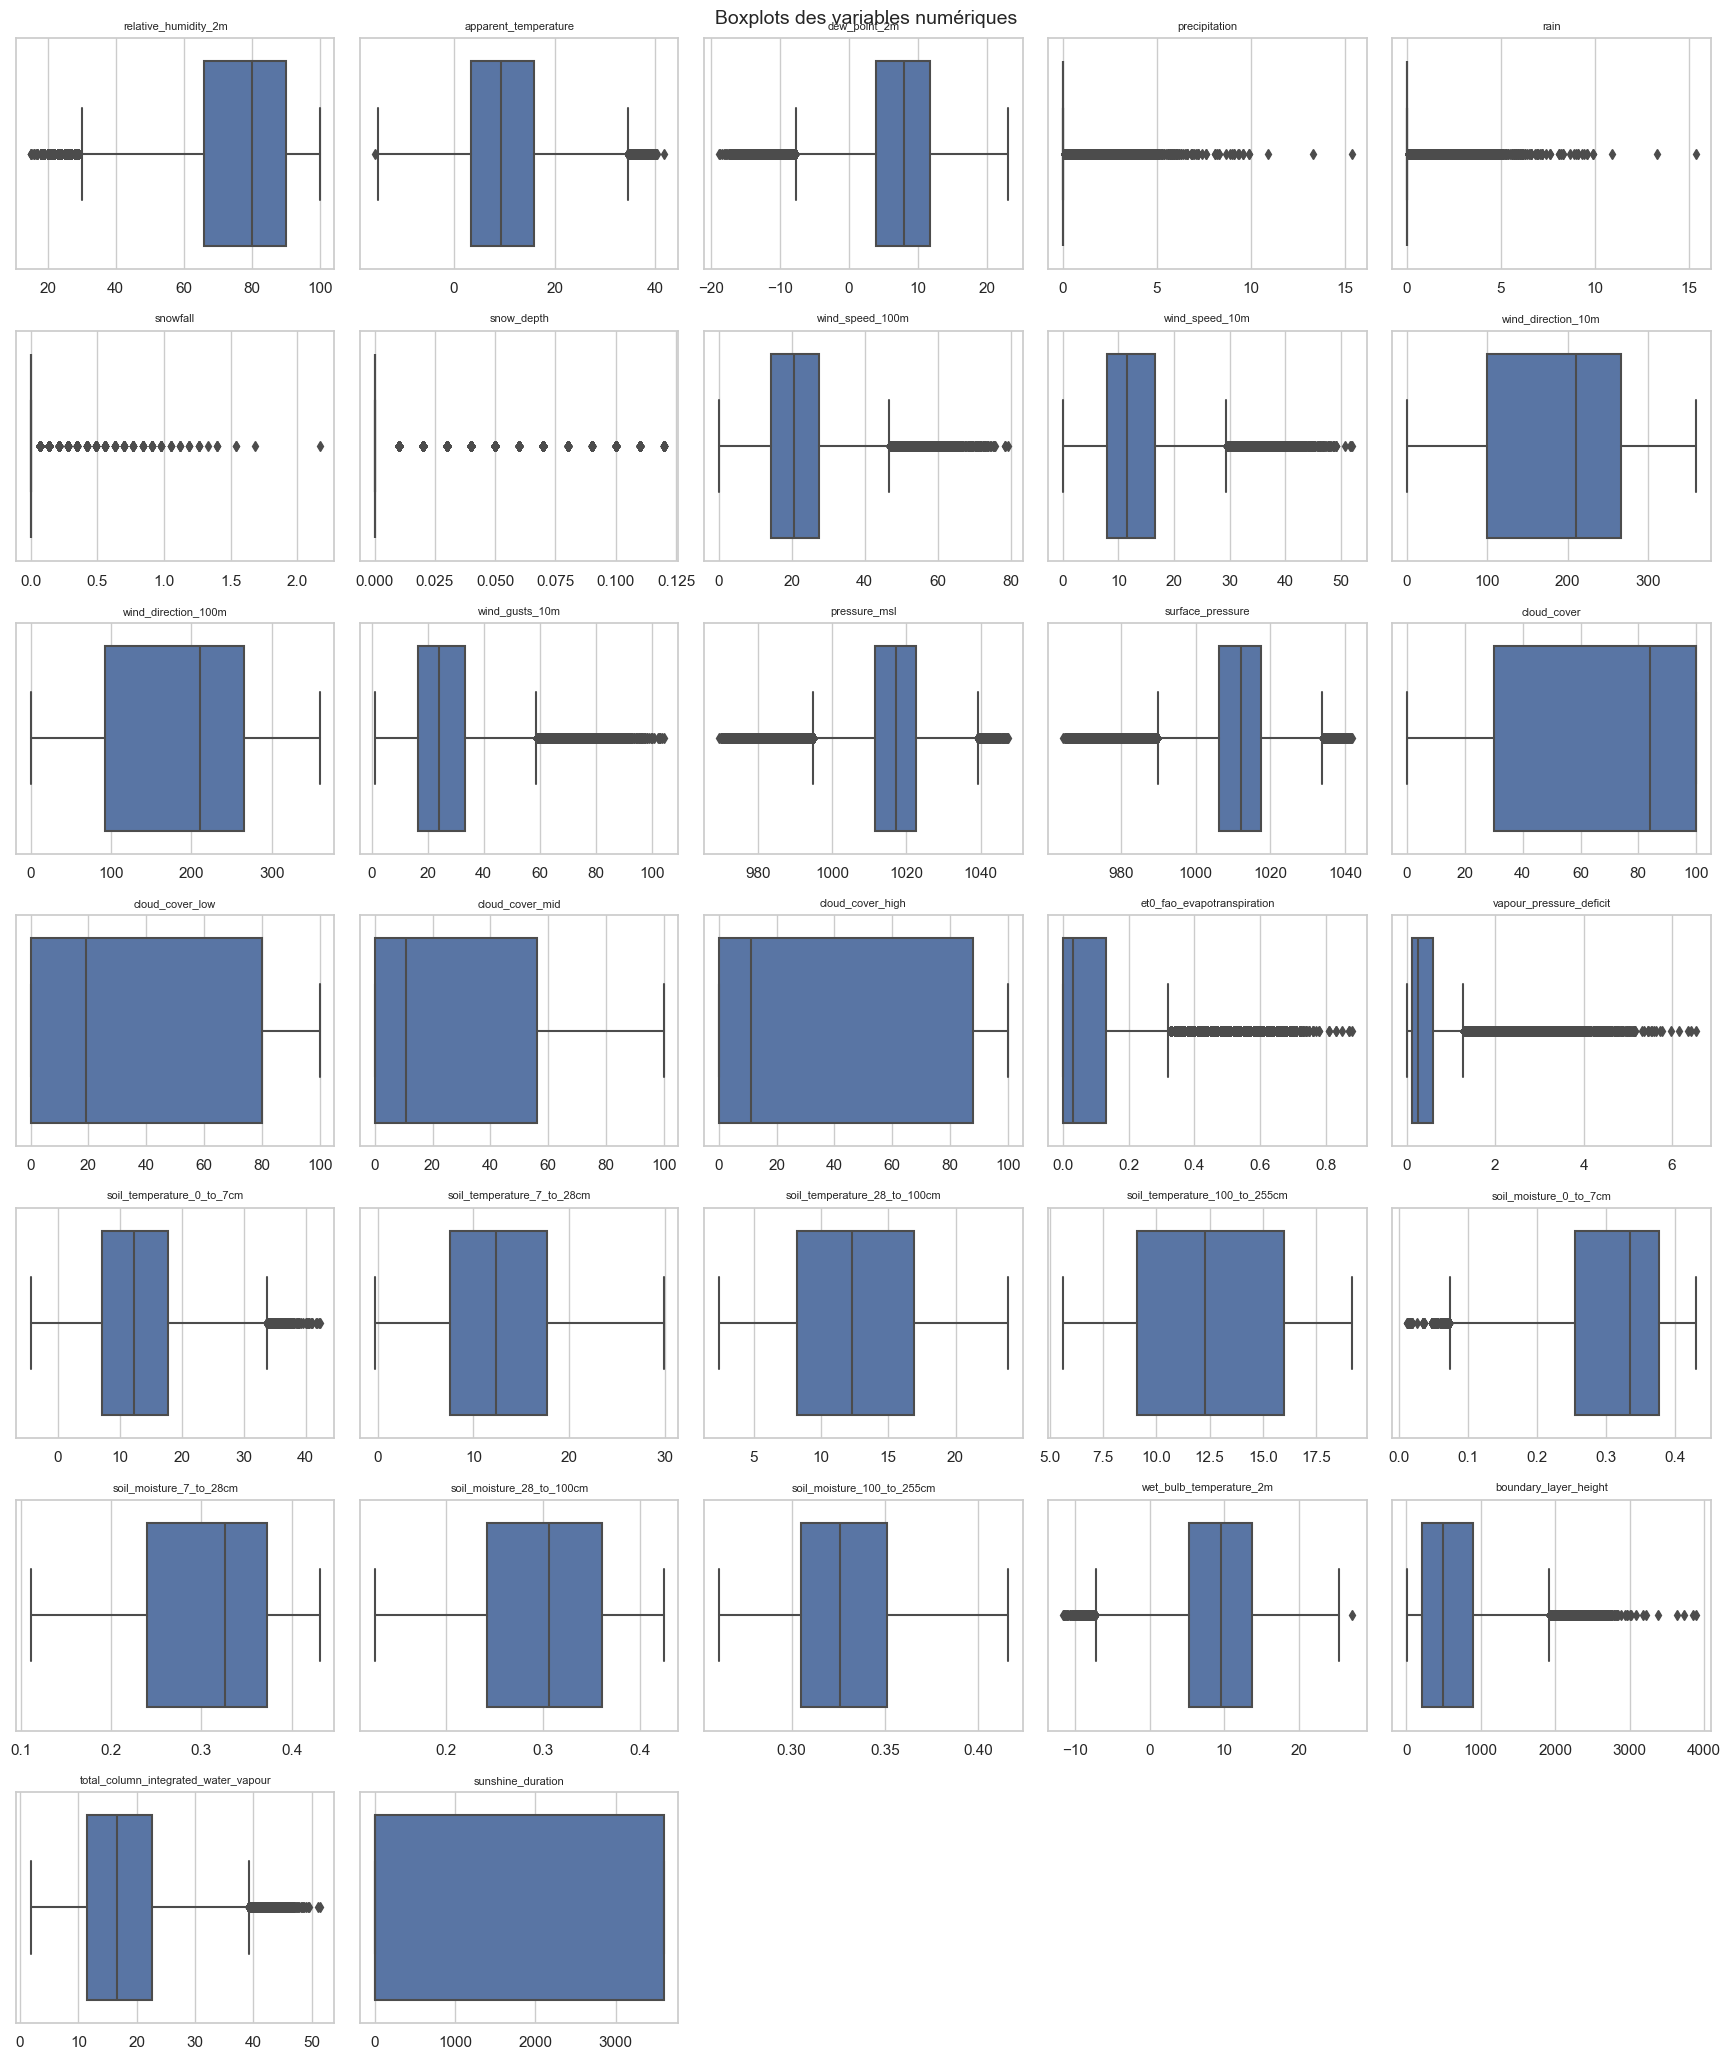

In [37]:
def plot_boxplots(df, columns, cols=5, bins=40):
    rows = math.ceil(len(columns) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.5, rows*3))
    axes = axes.flatten()
    for i, c in enumerate(columns):
        sns.boxplot(x=df[c].dropna(), ax=axes[i])
        axes[i].set_title(c, fontsize=8)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    fig.suptitle('Boxplots des variables numériques', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_boxplots(df, num_cols)

 Les boxplots confirment les tendances déjà observées sur les distributions des variables :



     - La plupart des variables présentent une dispersion cohérente avec la variabilité météorologique.

     - Certaines variables, comme les vitesses de vent, les précipitations, la durée d’ensoleillement ou la hauteur de la couche limite atmosphérique, montrent quelques valeurs extrêmes isolées. Ces points correspondent à des événements climatiques réels (rafales, averses, canicules, etc.) et non à des erreurs de mesure.

     - Les variables liées au sol (températures et humidité) apparaissent plus stables et sans outliers notables.



 Aucune donnée ne semble aberrante ni physiquement incohérente : ces valeurs extrêmes seront donc conservées.

 Elles pourront toutefois être encadrées au moment de la transformation des variables par des transformations logarithmiques (log(x+1)) ou un encodage binaire (ex. soleil / pas de soleil) afin de limiter leur influence sur les modèles sensibles aux valeurs extrêmes.

 ## 3.3 Corrélation des variables avec la cible temperature_2m

temperature_2m                          1.000000
apparent_temperature                    0.988635
soil_temperature_0_to_7cm               0.977001
wet_bulb_temperature_2m                 0.964210
soil_temperature_7_to_28cm              0.887182
dew_point_2m                            0.849685
soil_temperature_28_to_100cm            0.781438
vapour_pressure_deficit                 0.771244
total_column_integrated_water_vapour    0.728010
et0_fao_evapotranspiration              0.639196
sunshine_duration                       0.421886
soil_temperature_100_to_255cm           0.410383
boundary_layer_height                   0.379364
wind_gusts_10m                          0.078993
cloud_cover_high                        0.048505
wind_direction_100m                     0.041535
wind_direction_10m                      0.038632
rain                                    0.031753
precipitation                           0.023292
cloud_cover_mid                         0.007062
soil_moisture_100_to

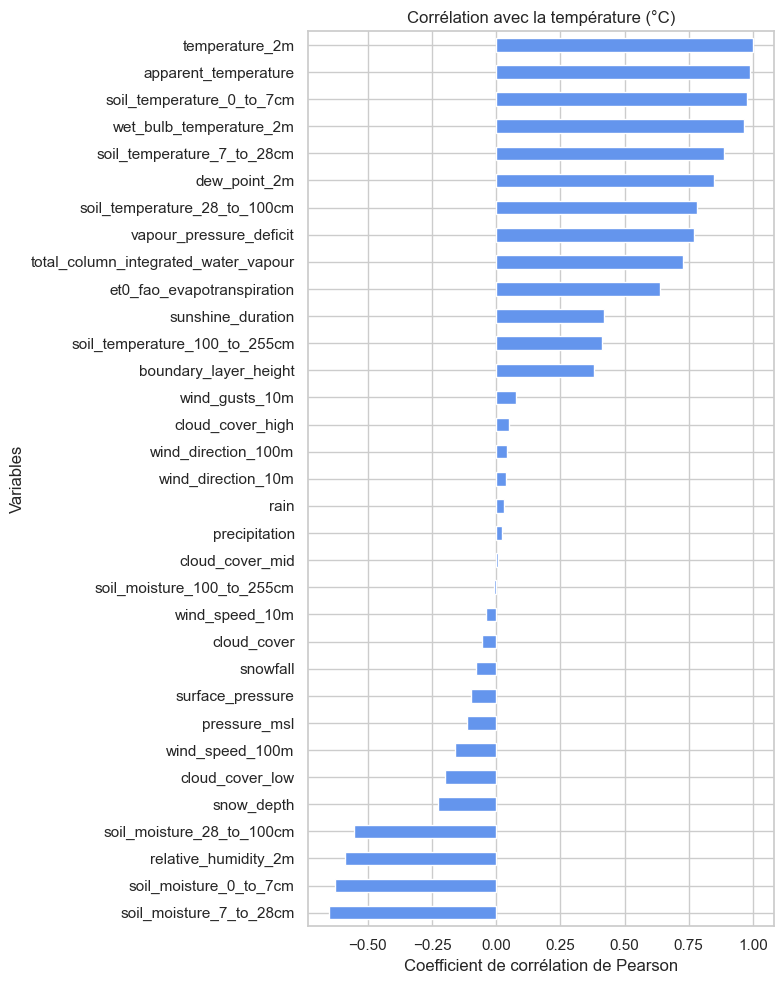

In [16]:
corr_matrix = df[num_cols + ['temperature_2m']].corr()
corr_with_target = corr_matrix['temperature_2m'].sort_values(ascending=False)
display(corr_with_target)
plt.figure(figsize=(8,10))
corr_with_target.sort_values().plot(kind='barh', color='cornflowerblue')
plt.title('Corrélation avec la température (°C)')
plt.xlabel('Coefficient de corrélation de Pearson')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()

 - Corrélations positives fortes :



     * Les variables les plus corrélées sont apparent_temperature, wet_bulb_temperature_2m, dew_point_2m et les températures du sol (soil_temperature_*).

     * Ces variables traduisent directement la chaleur ressentie ou la diffusion thermique du sol → corrélation très élevée (r > 0.84).

     * vapour_pressure_deficit, total_column_integrated_water_vapour et et0_fao_evapotranspiration montrent aussi une relation positive nette avec la température : plus l’air est chaud et sec, plus ces paramètres augmentent.

     * sunshine_duration et boundary_layer_height sont également positivement liées à la température, reflétant la dynamique diurne et les conditions d’ensoleillement.



 - Corrélations négatives :



     * L’humidité relative (relative_humidity_2m) et les humidités du sol (soil_moisture_*) présentent des corrélations négatives marquées : plus la température est élevée, plus l’air et le sol tendent à être secs.

     * Les pressions et certaines mesures de couverture nuageuse sont légèrement négatives, indiquant un effet de compensation (temps chaud souvent associé à pression plus basse ou ciel plus dégagé).



 - Corrélations faibles ou neutres :



     * Les variables de vent et de précipitations présentent des corrélations proches de zéro : leur influence sur la température n’est pas linéaire.



 Interprétation et implications : 

     - Les variables thermiques et hydriques expliquent l’essentiel de la variance de la température, certaines sont très redondantes (ex. apparent_temperature, dew_point, températures du sol) → À regrouper ou réduire (éviter redondance) 

     - Les variables négativement corrélées (humidité, sol) apportent une information complémentaire sur les échanges énergétiques --> À conserver : complément d’information 

     - Les variables neutres (vent, pluie, pression) restent intéressantes pour les modèles non linéaires (ex. arbres de décision, réseaux de neurones) même si leur corrélation linéaire est faible

 ## 3.4 Visualisation des corrélations entre les variables

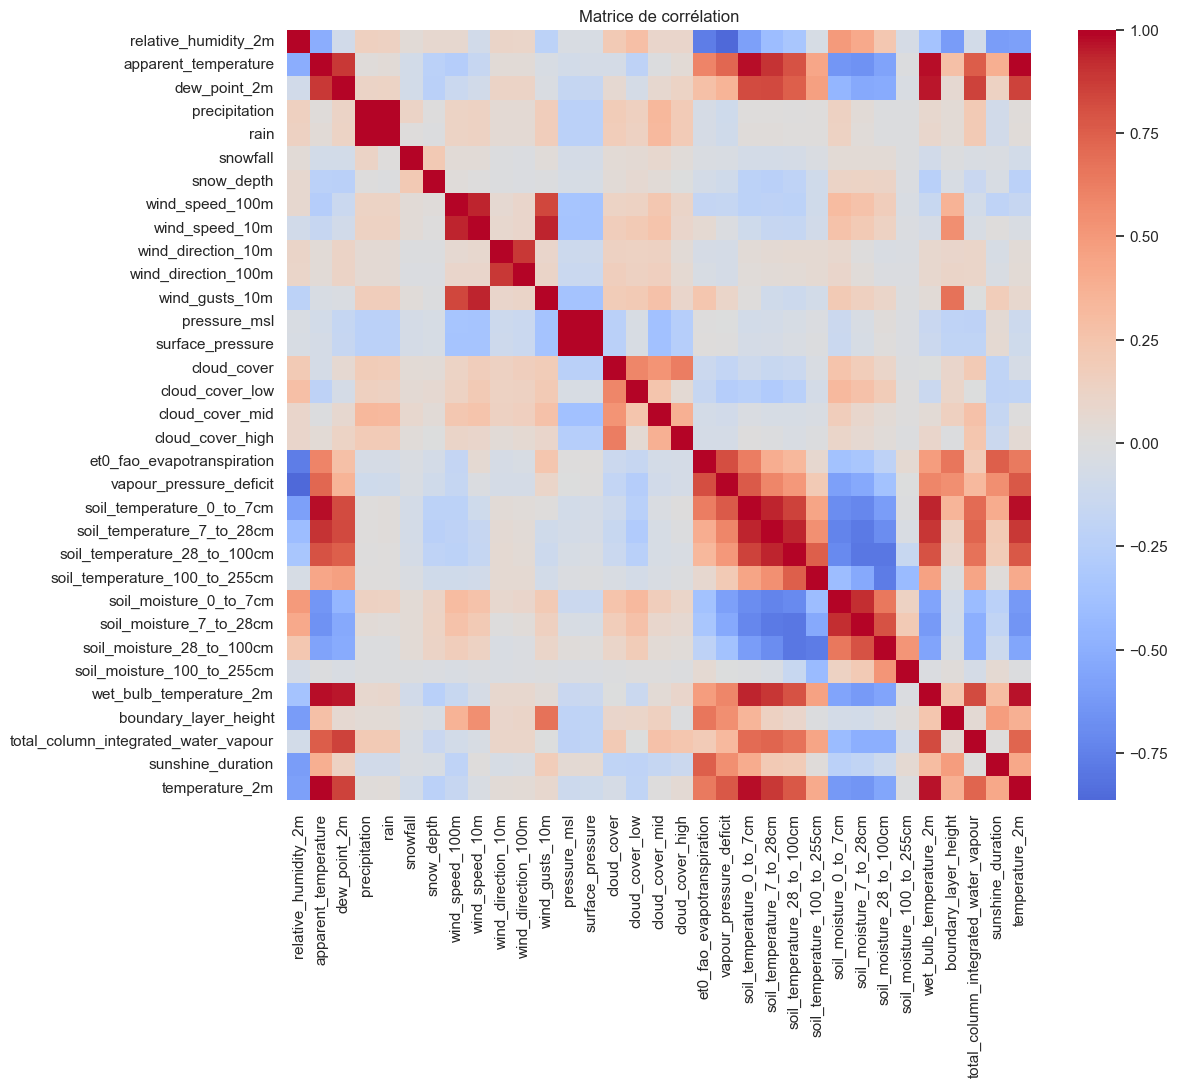

In [32]:
def plot_heatmap(M):
    plt.figure(figsize=(12,10))
    sns.heatmap(M, annot=False, cmap='coolwarm', center=0)
    plt.title("Matrice de corrélation")
    plt.show()
plot_heatmap(corr_matrix)

 Cette heatmap met en évidence plusieurs blocs fortement corrélés correspondant à des familles physiques :


| Groupe physique | Variables principales | Relations observées | Interprétation physique | Implications pour la modélisation |
|-----------------|----------------------|---------------------|-------------------------|-----------------------------------|
| Température | `temperature_2m`, `apparent_temperature`, `wet_bulb_temperature_2m`, `dew_point_2m`, `soil_temperature_*` | Corrélations très fortes (r > 0.9) | Même dynamique thermique à différentes altitudes et profondeurs | Éviter la redondance : sélectionner une variable représentative autre que `temperature_2m` (variable expliquée)|
| Humidité & vapeur d’eau | `relative_humidity_2m`, `vapour_pressure_deficit`, `total_column_integrated_water_vapour` | Corrélations négatives| Échanges thermodynamiques air–eau cohérents | Conserver des variables complémentaires plutôt que redondantes |
| Sol – humidité | `soil_moisture_*` | Forte corrélation inter-couches (r > 0.8) | Continuité verticale de l’humidité du sol | Une profondeur ou une moyenne peut suffire |
| Radiation & énergie | `et0_fao_evapotranspiration`, `sunshine_duration`, `boundary_layer_height`, `vapour_pressure_deficit` | Corrélations positives | Journées chaudes, ensoleillées et énergétiquement actives | Groupe informatif mais partiellement redondant |
| Vent | `wind_speed_*`, `wind_gusts_10m`, `wind_direction_*` | Corrélations modérées pour vitesses, faibles pour directions | Intensité liée mais directions indépendantes | Éventuellement : Conserver vitesses + encodage cyclique directions |
| Nuages & précipitations | `cloud_cover_*`, `precipitation`, `rain`, `snowfall` | Corrélations positives entre nuages, pluie et neige | Régimes météorologiques cohérents | Regroupement ou agrégation possible |



 Conclusion et implications :

     - Le dataset présente des corrélations logiques et cohérentes avec la physique du climat.

     - Pour la modélisation, il sera utile de : réduire la dimension (par sélection ou moyenne des variables redondantes), conserver une variable par groupe physique, vérifier la multicolinéarité.



## 4. Choix des variables retenues

À la suite de l’analyse exploratoire (distributions, valeurs manquantes, outliers, corrélations et cohérence physique), nous avons retenu un sous-ensemble réduit de variables pertinentes pour la prédiction de **temperature_2m**.  
Ce choix repose sur trois critères : **pertinence physique**, **corrélation statistique** et **réduction de la redondance**.


### Variables retenues pour la modélisation

| Variable | Rôle physique | Corrélation avec `temperature_2m` | Justification du choix |
|--------|---------------|-----------------------------------|-----------------------|
| `dew_point_2m` | Contenu en vapeur d’eau / chaleur latente | Forte (r ≈ 0.9) | Variable thermodynamique directement lié à la quantité de vapeur d’eau dans l’air et à la chaleur latente | 
| `soil_temperature_0_to_7cm` | Inertie thermique du sol | Forte (r ≈ 0.9) | Représente le stockage de chaleur profondeurs redondantes, reflète l’inertie thermique et le rayonnement solaire absorbé | 
| `soil_moisture_0_to_7cm` | Humidité du sol | Modérée négative | Influence le réchauffement du sol (sol sec → plus chaud) | 
| `sunshine_duration` | Rayonnement solaire reçu | Positive nette | Capture la dynamique diurne et le forçage radiatif | 
| `is_day` | Cycle jour / nuit | Relation Non linéaire | Encode le cycle diurne structurant la température | 


Ces variables fournissent un ensemble compact, non redondant et physiquement cohérent pour la prédiction de la température.


<h1 style="color: #b41f1fff;">III . Analyses Descriptive Détaillée des Variables Retenues</h1>

## 1 . Analyse détaillée des cinq variables 

Cette section présente l’analyse descriptive détaillée des cinq variables retenues pour la modélisation :  
**dew_point_2m**, **soil_temperature_0_to_7cm**, **soil_moisture_0_to_7cm**, **sunshine_duration**, **is_day**.

In [18]:
vars_selected = ['dew_point_2m',
                 'soil_temperature_0_to_7cm',
                 'soil_moisture_0_to_7cm',
                 'sunshine_duration',
                 'is_day',
                 'temperature_2m']  

df_sel = df[vars_selected]
col_selected = [c for c in df_sel.columns] 

In [19]:
df_sel.describe().T

,count,mean,std,min,25%,50%,75%,max
dew_point_2m,226320.0,7.603514,5.543304,-18.900,3.900,8.000,11.700,23.100
soil_temperature_0_to_7cm,226320.0,12.649639,7.092832,-4.400,7.200,12.300,17.800,42.300
soil_moisture_0_to_7cm,226320.0,0.310598,0.082905,0.011,0.255,0.335,0.377,0.431
sunshine_duration,226320.0,1128.875400,1605.492029,0.000,0.000,0.000,3600.000,3600.000
is_day,226320.0,0.510317,0.499895,0.000,0.000,1.000,1.000,1.000
temperature_2m,226320.0,12.039332,7.105220,-10.500,7.000,11.900,17.000,40.900


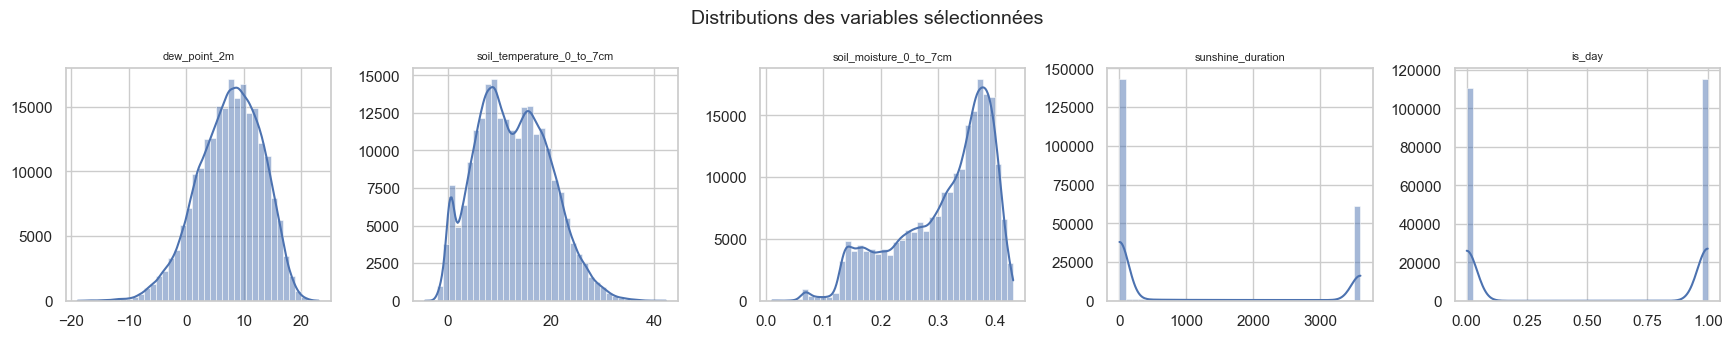

In [24]:
def plot_selected_variables_distributions(df, columns, cols=5, bins=40):
    cols_to_plot = [c for c in columns if c != "temperature_2m"]
    rows = math.ceil(len(columns) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.5, rows*3))
    axes = axes.flatten()
    for i, c in enumerate(cols_to_plot):
        sns.histplot(df[c], bins=bins, kde=True, ax=axes[i])
        axes[i].set_title(c, fontsize=8)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    fig.suptitle('Distributions des variables sélectionnées', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_selected_variables_distributions(df_sel, col_selected)

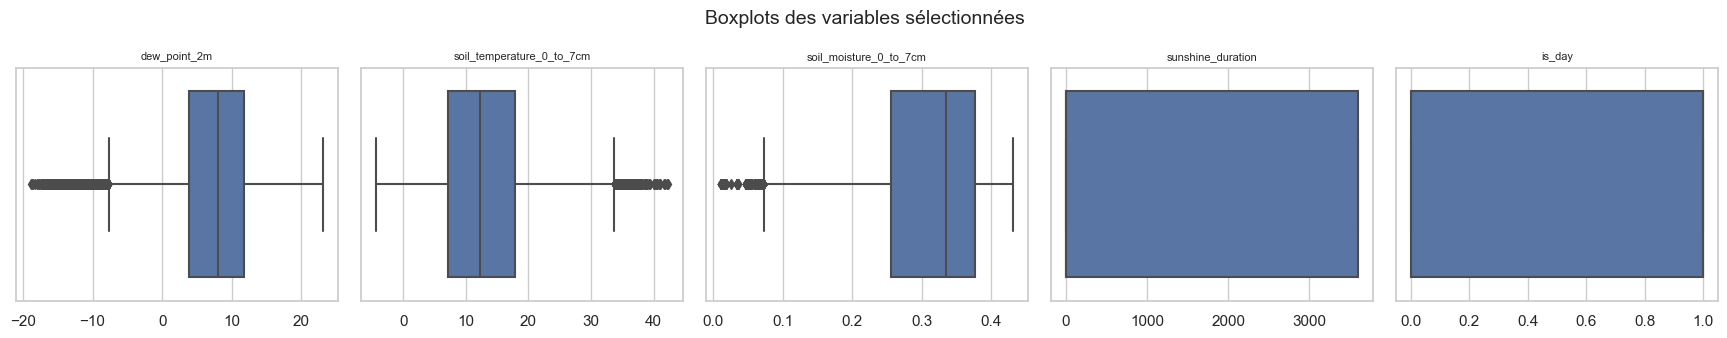

In [28]:

def plot_selected_variables_boxplots(df, columns, cols=5, bins=40):
    cols_to_plot = [c for c in columns if c != "temperature_2m"]
    rows = math.ceil(len(columns) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.5, rows*3))
    axes = axes.flatten()
    for i, c in enumerate(cols_to_plot):
        sns.boxplot(x=df[c].dropna(), ax=axes[i])
        axes[i].set_title(c, fontsize=8)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    fig.suptitle('Boxplots des variables sélectionnées', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_selected_variables_boxplots(df_sel, col_selected)

## Analyse des résultats : 


### Synthèse de l’analyse univariée des variables retenues

| Variable | Distribution | Outliers | Interprétation physique | Apport pour la modélisation |
|--------|--------------|----------|--------------------------|-----------------------------|
| `dew_point_2m` | Quasi gaussienne, centrée ~8 °C, légère asymétrie négative | Quelques valeurs basses hivernales, physiquement cohérentes | Mesure directe du contenu en vapeur d’eau et de la chaleur latente | Forte corrélation avec la température (r ≈ 0.9), variable clé thermodynamique |
| `soil_temperature_0_to_7cm` | Multimodale (cycles saisonniers), légère asymétrie positive | Valeurs élevées en été (> 35 °C), non aberrantes | Inertie thermique du sol, stockage de chaleur | Capture le cycle thermique saisonnier et journalier |
| `soil_moisture_0_to_7cm` | Asymétrique, plateaux humides/secs | Quelques valeurs très faibles (sol sec), plausibles | Contrôle le bilan énergétique sol–air | Complémentaire à la température du sol (relation inverse) |
| `sunshine_duration` | Très creusée, pics à 0 et 3600 s | Aucun | Rayonnement solaire reçu par heure | Variable clé du réchauffement diurne |
| `is_day` | Binaire (0/1) | Aucun | Encode le cycle jour/nuit | Introduit une non-linéarité structurelle essentielle |



## Conclusion 

- Comme déjà mentionné, les cinq variables présentent des distributions cohérentes et physiquement plausibles. Les outliers identifiés correspondent à des phénomènes météorologiques réels.  
- Chaque variable apporte une information complémentaire utile pour expliquer la température horaire.  
- `sunshine_duration` et `is_day` décrivent le cycle diurne, tandis que `dew_point_2m`, `soil_temperature_0_to_7cm` et `soil_moisture_0_to_7cm` décrivent la dynamique thermique et hydrique du sol et de l’air.  

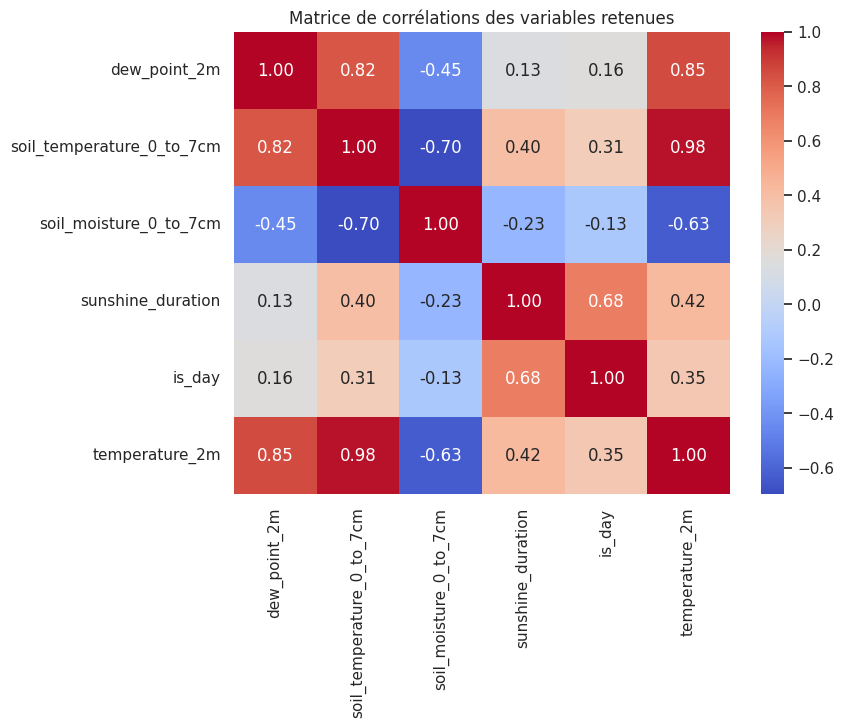

In [23]:
plt.figure(figsize=(8,6))
sns.heatmap(df_sel.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélations des variables retenues")
plt.show()

## 2. Analyse jour/nuit (variable is_day) : 

La variable is_day distingue deux régimes thermiques totalement différents :
* Jour (1) : influence directe du rayonnement solaire → réchauffement.
* Nuit (0) : perte radiative → refroidissement progressif.

Afin de comprendre ces dynamiques et leur impact sur les relations entre variables, le dataset est décomposé en deux sous-ensembles.

In [24]:
df_day = df[df['is_day'] == 1].copy()
df_night = df[df['is_day'] == 0].copy()

df_day.shape, df_night.shape

((115495, 35), (110825, 35))

## 2.1 . Comparaison des statistiques de température jour / nuit : 

=== Statistiques de temperature_2m (Jour vs Nuit) ===


,mean,std,min,25%,50%,75%,max
Jour,14.470704,7.068409,-10.5,9.4,14.6,19.5,40.9
Nuit,9.505506,6.200587,-10.0,5.1,9.5,14.0,34.8


Histogrammes comparatifs (jour vs nuit)


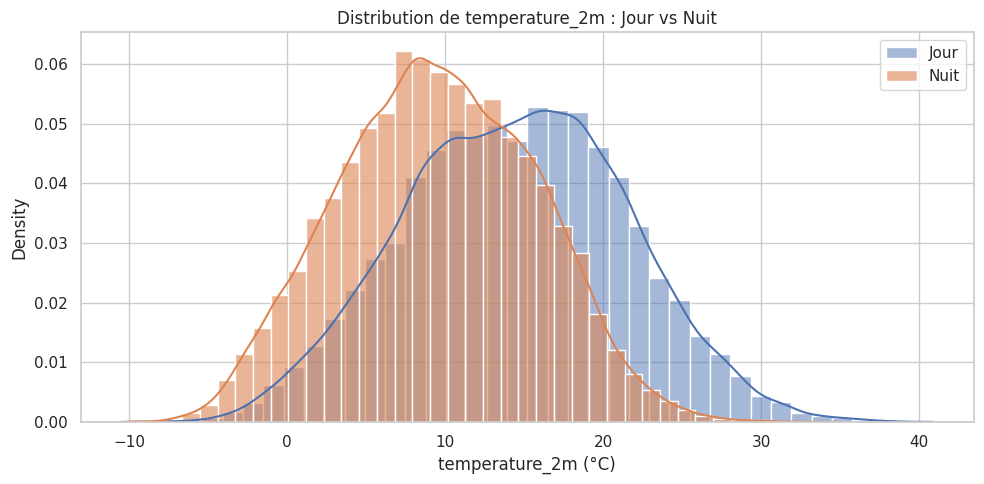

In [ ]:
temp_stats = pd.DataFrame({
    "mean": [df_day['temperature_2m'].mean(), df_night['temperature_2m'].mean()],
    "std":  [df_day['temperature_2m'].std(),  df_night['temperature_2m'].std()],
    "min":  [df_day['temperature_2m'].min(),  df_night['temperature_2m'].min()],
    "25%":  [df_day['temperature_2m'].quantile(0.25), df_night['temperature_2m'].quantile(0.25)],
    "50%":  [df_day['temperature_2m'].median(), df_night['temperature_2m'].median()],
    "75%":  [df_day['temperature_2m'].quantile(0.75), df_night['temperature_2m'].quantile(0.75)],
    "max":  [df_day['temperature_2m'].max(),  df_night['temperature_2m'].max()],
}, index=["Jour", "Nuit"])

print("=== Statistiques de temperature_2m (Jour vs Nuit) ===")
display(temp_stats)

print ("Histogrammes comparatifs (jour vs nuit)")

plt.figure(figsize=(10,5))
sns.histplot(df_day['temperature_2m'], bins=40, kde=True, label="Jour", stat="density")
sns.histplot(df_night['temperature_2m'], bins=40, kde=True, label="Nuit", stat="density", alpha=0.6)
plt.title("Distribution de temperature_2m : Jour vs Nuit")
plt.xlabel("temperature_2m (°C)")
plt.legend()
plt.tight_layout()
plt.show()



* La variance (ou l’écart-type) est plus forte le jour : la distribution est plus étalée.
* La nuit, la température est plus basse et la distribution est plus resserrée autour de la médiane.

## 2.2 . Corrélations des variables avec la température (Jour vs Nuit) : 

=== Corrélations avec temperature_2m (Jour vs Nuit) ===


,corr_day,corr_night
dew_point_2m,0.802970,0.926794
soil_temperature_0_to_7cm,0.977410,0.972285
soil_moisture_0_to_7cm,-0.649088,-0.607325
sunshine_duration,0.351269,0.048469


<Figure size 600x400 with 0 Axes>

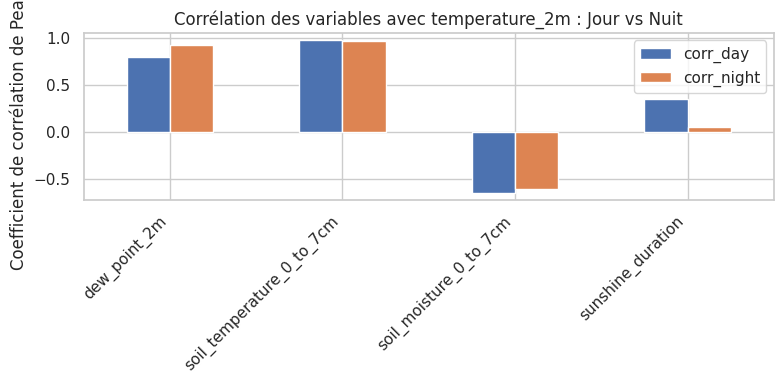

In [ ]:
vars_corr = ['dew_point_2m',
             'soil_temperature_0_to_7cm',
             'soil_moisture_0_to_7cm',
             'sunshine_duration']

# Corrélations jour
corr_day = df_day[vars_corr + ['temperature_2m']].corr()['temperature_2m'].drop('temperature_2m')
# Corrélations nuit
corr_night = df_night[vars_corr + ['temperature_2m']].corr()['temperature_2m'].drop('temperature_2m')

corr_compare = pd.DataFrame({
    "corr_day": corr_day,
    "corr_night": corr_night
})

print("=== Corrélations avec temperature_2m (Jour vs Nuit) ===")
display(corr_compare)
plt.figure(figsize=(6,4))
corr_compare.plot(kind='bar', figsize=(8,4))
plt.title("Corrélation des variables avec temperature_2m : Jour vs Nuit")
plt.ylabel("Coefficient de corrélation de Pearson")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 2.3 Scatterplots jour/nuit pour voir la forme de la relation et détecter la linéarité 

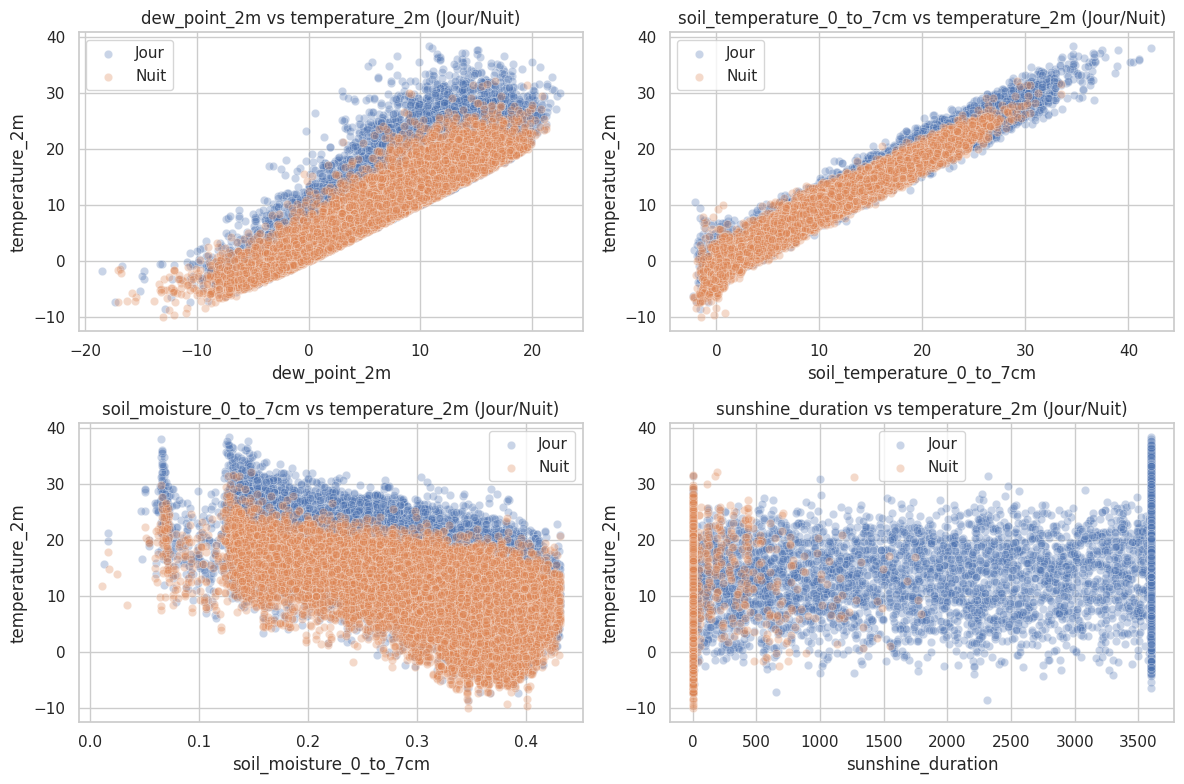

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes = axes.flatten()

for i, var in enumerate(vars_corr):
    sns.scatterplot(
        data=df_day.sample(20000, random_state=0),  # sous-échantillon pour alléger
        x=var, y='temperature_2m', alpha=0.3,
        ax=axes[i], label='Jour'
    )
    sns.scatterplot(
        data=df_night.sample(20000, random_state=1),
        x=var, y='temperature_2m', alpha=0.3,
        ax=axes[i], label='Nuit'
    )
    axes[i].set_title(f"{var} vs temperature_2m (Jour/Nuit)")

plt.tight_layout()
plt.show()


### Analyse des corrélations conditionnelles (jour / nuit)

| Variable | Corrélation de jour | Corrélation de nuit | Interprétation physique | Apport pour la modélisation |
|--------|--------------------|---------------------|--------------------------|-----------------------------|
| `dew_point_2m` | Forte | Très forte | La nuit, l’humidité de l’air suit directement le refroidissement thermique | Capture le régime thermique nocturne |
| `soil_temperature_0_to_7cm` | Très forte | Forte | Le jour, sol et air se réchauffent conjointement sous l’effet du rayonnement | Capture la dynamique de réchauffement diurne |
| `soil_moisture_0_to_7cm` | Négative (non linéaire) | Négative | Un sol sec se réchauffe plus rapidement qu’un sol humide | Information complémentaire sur l’état de surface |
| `sunshine_duration` | Positive | Nulle | Variable informative uniquement en journée | Justifie un indicateur binaire (`sunny`) |


### Conclusion de l’analyse jour / nuit

La décomposition du dataset en deux régimes jour et nuit met en évidence des dynamiques thermiques fondamentalement différentes.

- Le jour, la température est fortement influencée par le rayonnement solaire et une variabilité météorologique rapide.  
- La nuit, elle évolue selon un mécanisme plus simple et plus stable dominé par le refroidissement radiatif.

### Points clés mis en évidence

- Les relations statistiques entre la température et les variables explicatives changent selon le régime, forces de corrélation différentes, linéarités différentes.

- Certains prédicteurs n’agissent que dans un seul régime
  - Exemple : `sunshine_duration` uniquement le jour.  
  - Exemple : `dew_point_2m` corrélé plus fortement la nuit.

- Le cycle diurne introduit une hétérogénéité structurelle que les modèles doivent impérativement intégrer.

Ces différences ont des implications directes pour la préparation des données : création de variables dérivées, gestion de la non-linéarité...



## 3. Analyse ensoleillé / pas ensoleillé

## 3.1 Création de la variable binaire is_sunny à partir de la variable sunshine_duration : 

In [29]:
df["is_sunny"] = (df["sunshine_duration"] > 0).astype(int)

# Répartition globale
print(df["is_sunny"].value_counts())
print(df["is_sunny"].value_counts(normalize=True))

# Sunny vs not sunny, croisé avec jour/nuit
display(pd.crosstab(df["is_day"], df["is_sunny"], normalize="index"))

is_sunny
0    142178
1     84142
Name: count, dtype: int64
is_sunny
0    0.628217
1    0.371783
Name: proportion, dtype: float64


is_sunny,0,1
is_day,,
0,0.984399,0.015601
1,0.286437,0.713563


### Analyse de la variable binaire ensoleillé / pas ensoleillé (`is_sunny`)

À partir de la variable continue `sunshine_duration`, une variable binaire `is_sunny` a été construite :
- `is_sunny = 1` si `sunshine_duration > 0` (présence d’ensoleillement),
- `is_sunny = 0` sinon.

#### Répartition globale
La variable `is_sunny` est déséquilibrée :
- Environ 37.7 % des observations correspondent à des périodes ensoleillées,
- Environ 62.3 % correspondent à des périodes sans ensoleillement.

Cette dissymétrie est cohérente avec un climat tempéré, où les périodes nuageuses, nocturnes ou faiblement ensoleillées sont majoritaires.

#### Lien avec le cycle jour / nuit
L’analyse croisée avec la variable `is_day` met en évidence une structure claire :

- La nuit (`is_day = 0`) :
  - Plus de 98 % des observations sont non ensoleillées (`is_sunny = 0`).
  - L’ensoleillement est donc quasi inexistant, ce qui confirme la cohérence physique de la variable.

- Le jour (`is_day = 1`) :
  - Environ 71 % des observations sont ensoleillées,
  - Environ 29 % correspondent à des journées couvertes ou très nuageuses.

Ainsi, `is_sunny` n’apporte aucune information supplémentaire la nuit, mais permet de distinguer efficacement les journées ensoleillées des journées nuageuses pendant la journée.
On observe une faible proportion de cas `is_sunny=1` alors que `is_day=0` (~1–2%). Cela s’explique probablement par les périodes de transition (aube/crépuscule). 

### Interprétation physique
- La variable `is_sunny` capture un effet radiatif direct lié à la présence ou non de rayonnement solaire.
- Elle agit comme un raffinement du régime diurne, complémentaire de `is_day` :
  - `is_day` encode la présence potentielle de soleil,
  - `is_sunny` encode la réalité effective de l’ensoleillement.

## 3.2 Tempêrature x is_sunny 

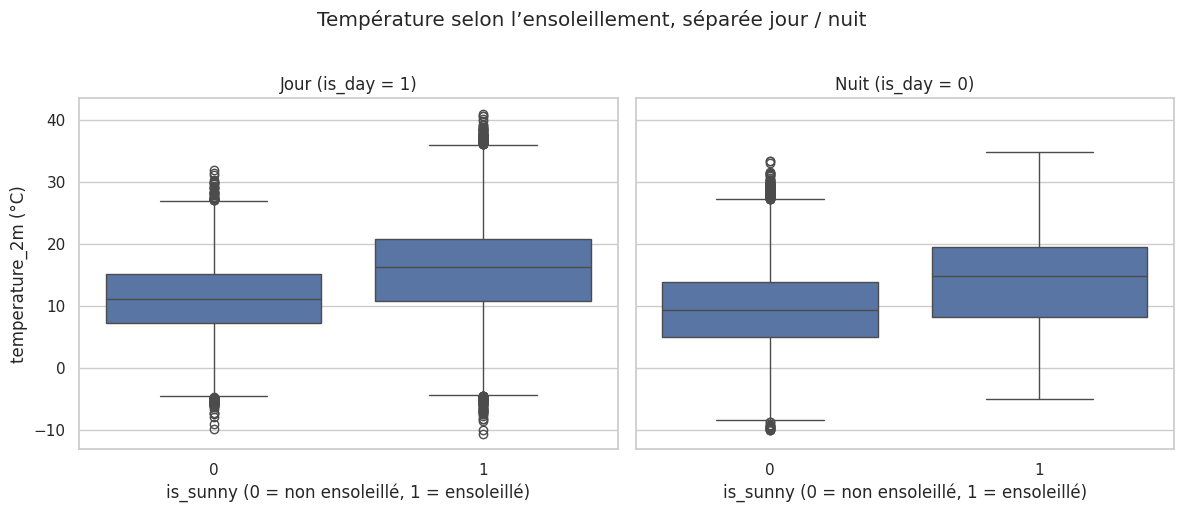

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Jour
sns.boxplot(
    data=df[df["is_day"] == 1],
    x="is_sunny",
    y="temperature_2m",
    ax=axes[0]
)
axes[0].set_title("Jour (is_day = 1)")
axes[0].set_xlabel("is_sunny (0 = non ensoleillé, 1 = ensoleillé)")
axes[0].set_ylabel("temperature_2m (°C)")

# Nuit
sns.boxplot(
    data=df[df["is_day"] == 0],
    x="is_sunny",
    y="temperature_2m",
    ax=axes[1]
)
axes[1].set_title("Nuit (is_day = 0)")
axes[1].set_xlabel("is_sunny (0 = non ensoleillé, 1 = ensoleillé)")
axes[1].set_ylabel("")

plt.suptitle("Température selon l’ensoleillement, séparée jour / nuit", y=1.02)
plt.tight_layout()
plt.show()


La séparation jour / nuit est indispensable pour interpréter correctement l’effet de
l’ensoleillement. Sans cette distinction, l’influence de `is_sunny` serait masquée par
les observations nocturnes, où l’ensoleillement est absent : 
Régime diurne (jour)
- Une différence apparaît entre les heures ensoleillées (`is_sunny = 1`) et
  les heures non ensoleillées (`is_sunny = 0`).
- Les heures ensoleillées présentent :
  - une médiane plus élevée,
  - une dispersion plus importante, avec des valeurs maximales plus élevées.
- Les heures diurnes sans ensoleillement sont associées à des températures plus modérées,
  traduisant l’absence de réchauffement radiatif direct.

**Régime nocturne (nuit)**  
- La grande majorité des observations correspond à `is_sunny = 0`, ce qui est physiquement attendu.
- Les rares observations `is_sunny = 1` n’introduisent pas de séparation nette entre les distributions.
- La température nocturne est principalement gouvernée par le refroidissement radiatif,
  indépendamment de l’ensoleillement effectif.

**Interprétation**
- L’impact de l’ensoleillement sur la température est strictement diurne.
- La variable `is_sunny` agit comme un raffinement du régime diurne, en distinguant
  les heures réellement ensoleillées des heures couvertes.
- En revanche, `is_sunny` n’apporte pas d’information structurante la nuit.

## 3.3 Comparaison des histogrammes de température pendant la journée en fonction de l'ensoleillement de la journée: 

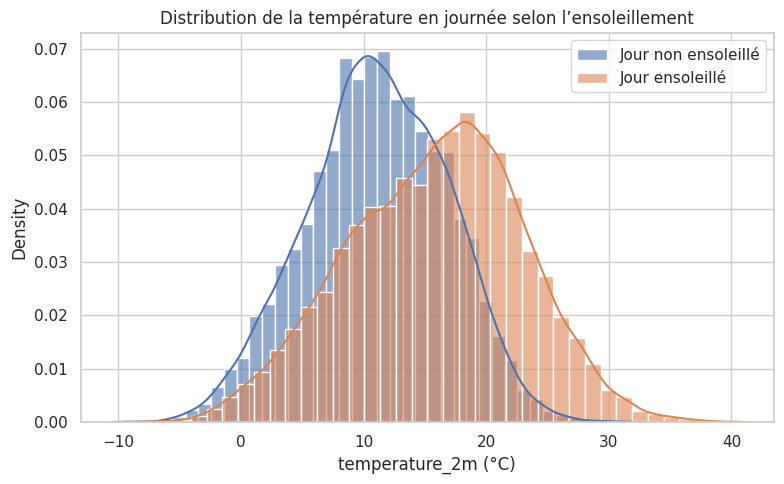

In [31]:
plt.figure(figsize=(8,5))
sns.histplot(
    df[(df["is_day"]==1) & (df["is_sunny"]==0)]["temperature_2m"],
    bins=40, kde=True, label="Jour non ensoleillé", stat="density", alpha=0.6
)
sns.histplot(
    df[(df["is_day"]==1) & (df["is_sunny"]==1)]["temperature_2m"],
    bins=40, kde=True, label="Jour ensoleillé", stat="density", alpha=0.6
)
plt.title("Distribution de la température en journée selon l’ensoleillement")
plt.xlabel("temperature_2m (°C)")
plt.legend()
plt.tight_layout()
plt.show()


#### Distribution de la température en journée selon l’ensoleillement

En se restreignant aux heures diurnes (`is_day = 1`), la distribution de la température
présente un décalage en présence d’ensoleillement effectif (`is_sunny = 1`).

Les heures ensoleillées sont associées à :
- des températures plus élevées en moyenne,
- une extension plus marquée vers les valeurs maximales.

À l’inverse, les heures diurnes sans ensoleillement correspondent à des
températures plus modérées et à une distribution plus resserrée.

Ce résultat confirme que l’impact de l’ensoleillement sur la température est correctement capturé par la variable `is_sunny` lorsqu’elle est
interprétée conditionnellement au régime jour.

<h1 style="color: #b41f1fff;">IV . Analyse et Synthèse Finales Orientées Modélisation des Variables Retenues</h1>

Après l’analyse descriptive, cette section résume les décisions de préparation et de transformation nécessaires pour la modélisation.  
L’objectif est de déterminer comment chaque variable doit être traitée pour optimiser la performance du modèle.


| Variable | Propriétés statistiques | Relation avec `temperature_2m` | Décision de modélisation | Justification |
|--------|-------------------------|--------------------------------|--------------------------|---------------|
| `dew_point_2m` | Distribution quasi gaussienne, valeurs extrêmes plausibles | Linéaire, forte corrélation | Standardisation (z-score) | Variable thermodynamique stable, pas de transformation non linéaire nécessaire |
| `soil_temperature_0_to_7cm` | Multimodale (cycles saisonniers), extrêmes cohérents | Linéaire et positive | Standardisation, surveillance de la multicolinéarité pour les modèles linéaires | Capture l’inertie thermique du sol, potentielle redondance avec autres variables thermiques |
| `soil_moisture_0_to_7cm` | Asymétrique, valeurs basses plausibles | Non linéaire, corrélation négative | Standardisation ; transformations dérivées à tester | Information complémentaire sur l’état de surface |
| `sunshine_duration` | Très déséquilibrée (0 / 3600 s) | Positive en journée, nulle la nuit | Conserver pour modèles non linéaires | Représente l’intensité du rayonnement solaire |
| `is_day` | Binaire | Relation non linéaire structurelle | Conserver tel quel | Encode le cycle diurne/nocturne |
| `is_sunny` | Binaire (dérivée de sunshine_duration) | Informative uniquement en journée | Variable dérivée prioritaire | Capture l’effet radiatif sans bruit nocturne, introduit une information non redondante avec `is_day`, en séparant journées ensoleillées (réchauffement radiatif fort) et journées couvertes (réchauffement limité). (Dans le cadre d’un modèle **LSTM multivarié**, `is_sunny` permet d’améliorer la représentation des transitions thermiques diurnes sans introduire de bruit nocturne inutile.)|

<h1 style="color: #b41f1fff;">V . Transition Vers l'Analyse Temporelle :</h1>

Les analyses présentées dans ce notebook exploitent l’ensemble du dataset, constitué
d’observations horodatées (une date/heure par ligne). Toutefois, l’approche adoptée
ici est dite statique au sens où les variables ont été étudiées de manière globale
sur l’ensemble des observations (distributions, corrélations, effets jour/nuit, effet
ensoleillement), sans exploiter explicitement l’ordre temporel des mesures.

Cependant, la température est par nature une variable temporelle, dont l’évolution dépend
non seulement des conditions instantanées, mais aussi de son historique récent.

Le Notebook 03 vise donc à explorer la structure temporelle des données afin de mieux comprendre
la dynamique d’évolution de la température au cours du temps.